# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Цель проекта

Необходимо пострить модель, которая будет предсказывать рыночную стоимость автомобиля. Оценка качества модели определяется метрикой RMSE. Значение метрики должно быть меньше 2500. При заявленном качестве по метрике, модель должна быть максимально быстродейственной.

## План работы

1. Загрузка данных.
2. Изучение и предобработка данных.
3. Подготовка выборки для машинного обучения.
4. Обучение моделей.
5. Оценка качества предсказания и время обучения моделей.
6. Выбор лучшей модели, по праматерам качество/время обучения, проверка на тестовой выборке.

## Описание данных

Признаки
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя


Целевой признак
- **Price** — цена (евро)

## Настройка окружения

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
!pip install lightgbm
from time import time
import warnings
warnings.filterwarnings('ignore')

### Функции

In [2]:
# функция изучения общих сведений по датафрейму
def data_exam(df):
    df.info()
    print('*' * 70)
    print('Размерность таблицы:' + '\n', df.shape)
    print('*' * 70)
    display(df.head(5))
    print('*' * 70)
    print('Количество пропусков:' + '\n', df.isna().sum())
    print('*' * 70)
    print('Названия столбцов:' + '\n', df.columns)
    print('*' * 70)
    print('Количество явных дубликатов:' + '\n', df.duplicated().sum())
    print('*' * 70)
    print('Уникальные значения в категориальных столбцах')
    print('-' * 70)
    list_object = []
    list_num = []
    for column in df.columns:
        if df[column].dtype == 'object':
            list_object.append(column)
        else:
            list_num.append(column)
    list_object.remove('DateCrawled')
    list_object.remove('DateCreated')
    list_object.remove('LastSeen')
    for value in list_object:
        print('Столбец', value, ':', df[value].unique())
        print('-' * 70)
    list_num.remove('NumberOfPictures')

    list_num.remove('PostalCode')
    print('*' * 70)
    print('Числовые столбцы')
    for i in list_num:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.hist(df[i], bins=10);
        ax1.set_title(i)
        ax1.set_xlabel('Значения')
        ax1.set_ylabel('Частота')
        ax2.boxplot(df[i]);
        ax2.set_title(i)
        plt.show()

## Подготовка данных

### Загрузка и изучение данных

In [3]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/autos.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**********************************************************************
Количество пропусков:
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64
**********************************************************************
Названия столбцов:
 Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')
**********************************************************************
Количество явных дубликатов:
 4


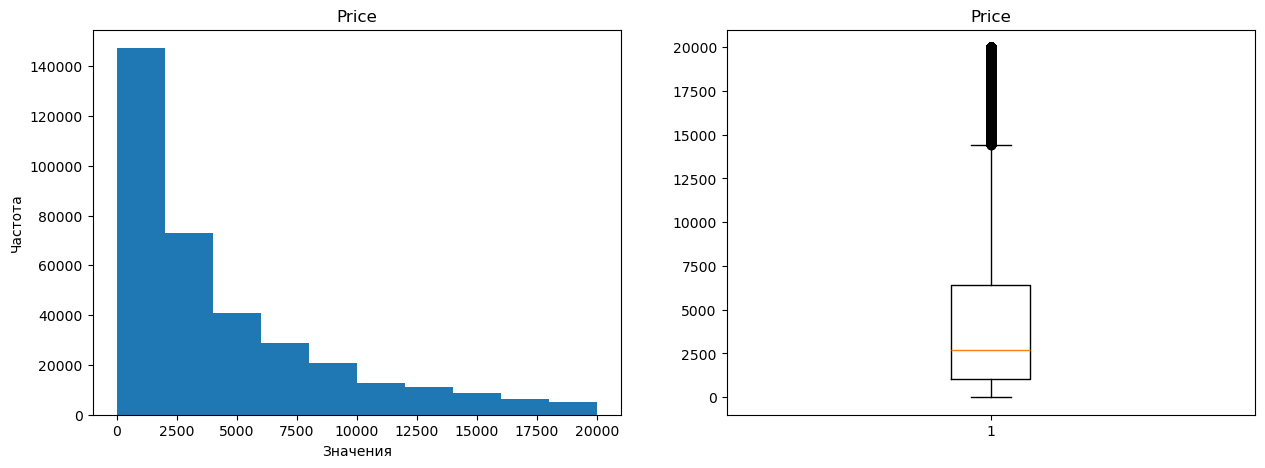

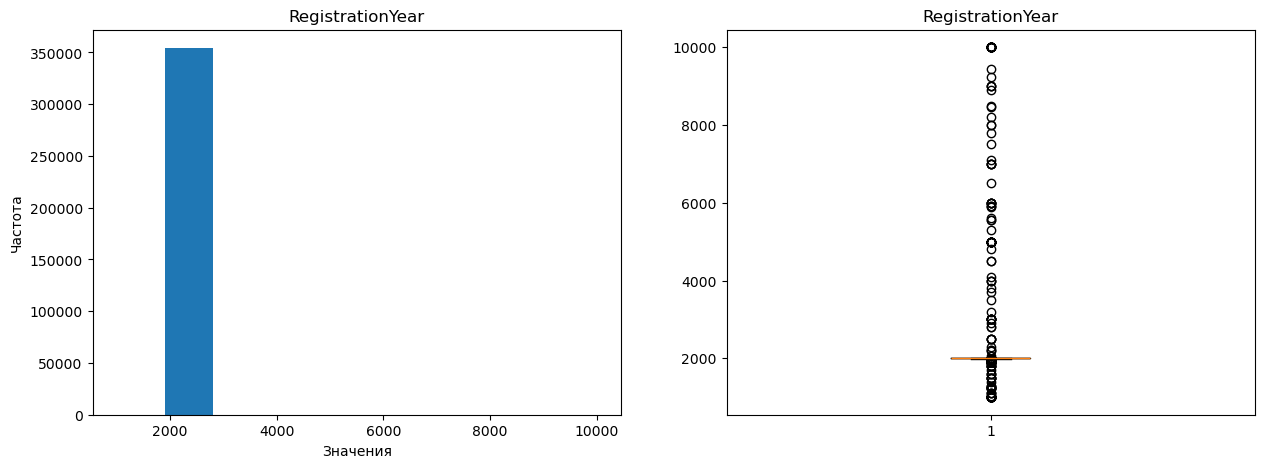

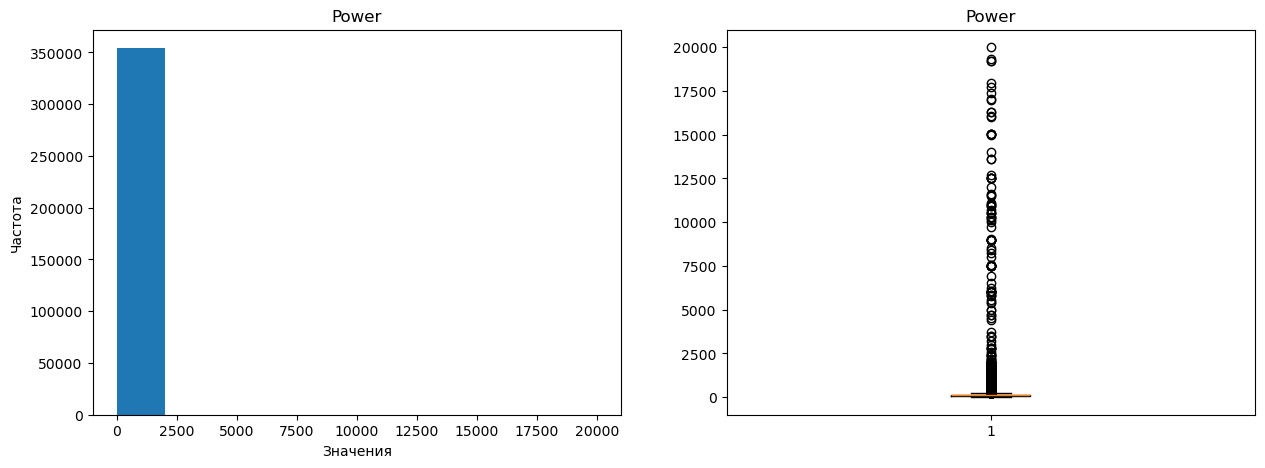

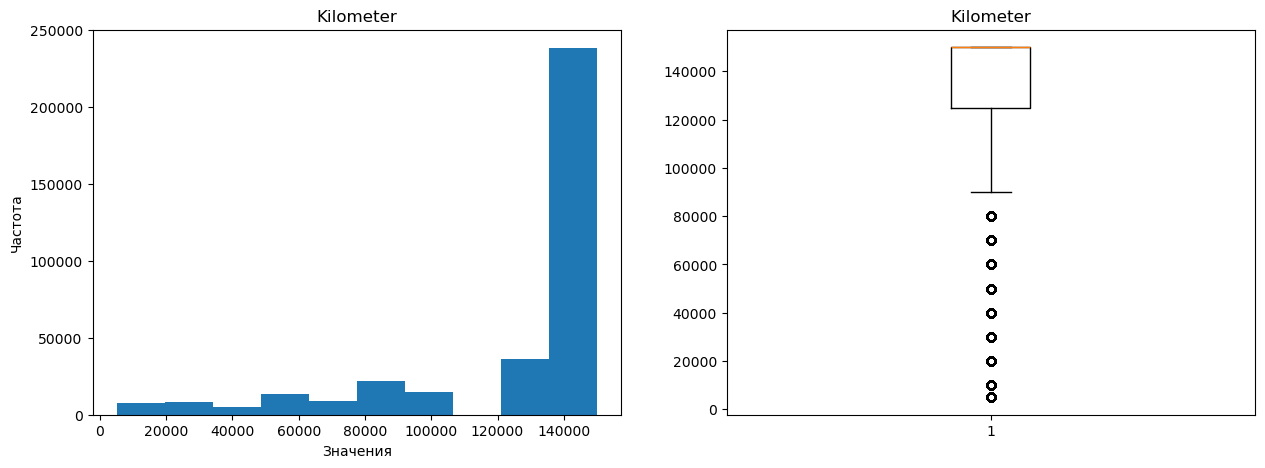

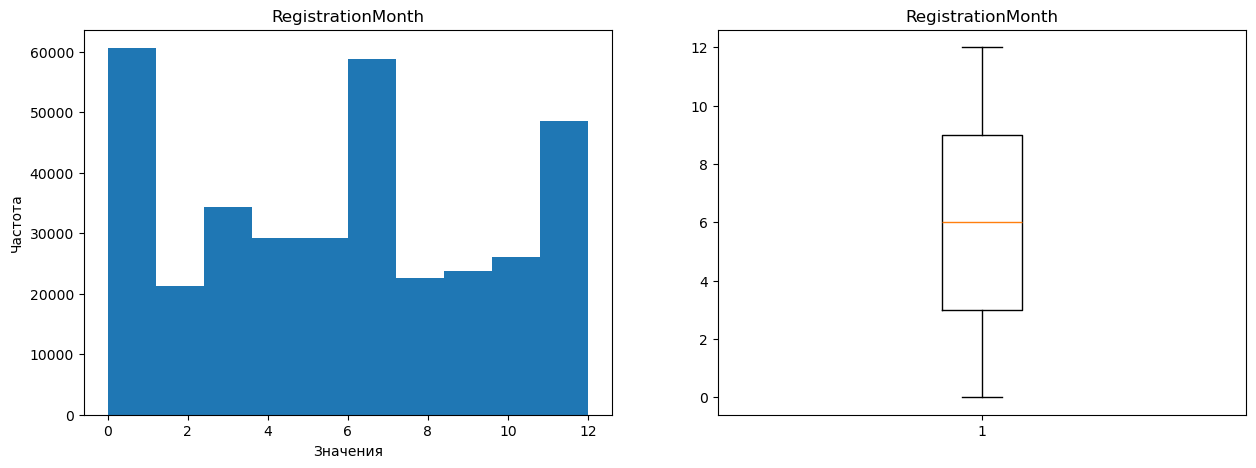

In [4]:
# исследуем данные
data_exam(df)

Загрузив и проведя первичный осмотр данных можно сделать следующие выводы:
  - данные загрузились корректно;
  - датафрейм содержит 354369 строк и 16 столбцов;
  - названия столбцов представлены в "верблюжьем" стиле, необходимо будет перевести в "змеиный";
  - в данных есть явные дубликаты, необходимо будет их удалить;
  - в данных незначимые для машинного обучения столбцы, а именно: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen, необходимо будет их удалить;
  - в некоторых значимых столбцах есть пропуски данных, необходимо будет их обработать;
  - в категориальных столбцах наблюдается неявное дублирование в названии категорий: в столбце FuelType встречается разное название одного и того же вида топлива - бензина ('petrol' и 'gasoline'); в столбце Model - разное написание одной модели rangerover и range_rover. это нужно будет учесть в предобработке данных;
  - во всех значимых числовых столбцах присутствуют выбросы, необходимо будет проработать и этот момент;
  - данные в столбце с годом регистрации автомобиля RegistrationYear, имеют целочисленный тип, что не является помехой для наших целей, данные имеют неправдоподобные выбросы из далекого прошлого и далекого будующего, необходимо будет поработать с этими выбросами;
  - данные в столбце с годом регистрации автомобиля RegistrationMonth имеют нулевые значения, при этом основная нумерация от 1 до 12, необходимо будет поработать с этими аномальными значениями;
  - данные в столбце с пробегом так же имеют выбросы в направлении малых пробегов, но это может быть вполне реальной картиной, даже для старых автомобилей, так не редкость, что машина может просто простоять в гараже, поэтому этот столбнц оставим как есть.

### Предобработка данных

#### Изменение стиля названий столбцов

In [5]:
#произведем приведение названий столбцов к змеиному стилю
df = df.rename(columns={'DateCrawled':'date_crawled', 'Price':'price', 'VehicleType':'vehicle_type',\
                        'RegistrationYear':'registration_year', 'Gearbox':'gearbox','Power':'power',\
                        'Model':'model', 'Kilometer':'kilometer', 'RegistrationMonth':'registration_month',\
                        'FuelType':'fuel_type', 'Brand':'brand', 'Repaired':'repaired', 'DateCreated':'date_created',\
                        'NumberOfPictures':'number_of_pictures', 'PostalCode':'postal_code', 'LastSeen':'last_seen'})

In [6]:
# проверим
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

#### Удаление явных дубликатов

In [7]:
# скопируем изначальный датафрейм для последующего определения количества удаленных данных
df_old = df.copy()

In [8]:
# произведем удаление явных дубликатов и проверим
df = df.drop_duplicates()
print(df.shape, df_old.shape)

(354365, 16) (354369, 16)


#### Удаление незначимых столбцов

In [9]:
# удалим незначимые для наших целей столбцы
df = df.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'date_crawled'], axis=1)

In [10]:
# проверим
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


#### Обработка аномалий в столбце 'registration_year'

При первичном осмотре данных, было определено, что в данном столбце присутствуют значения не соотвествующие действительности, взглянем подробнее.

In [11]:
# посмотрим крайние значения по столбцу
df['registration_year'].value_counts().sort_index()

registration_year
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: count, Length: 151, dtype: int64

Действительно, данные некорректны - некоторые автомобили зарегестрированы еще до начала эпохи автомобилестроения, а некотрые в далеком будущем. Очевидно, что некоторые данные были либо некорректно заполнены, либо произошли сбои при выгрузке базы. Какой-либо механизм исправления этих значений на корректные я не вижу. Остается вариант удалить их. Ограничим выборку 1960-м годом слева, так как машины данного года могут быть еще вполне на ходу и относительно массово продаваться, более старые машины уже будут относиться к раритеным автомобилям - данный рынок уже работает по другим законам, данный факт может исказить картину. Справа ограничим данные актуальной датой выгрузки базы данных. Определим год ограничения справа и проверим какй процент данных потенциально можем потерять, от первоначальной выборки.

In [12]:
pd.to_datetime(df_old['date_crawled']).max()

Timestamp('2016-04-07 14:36:58')

Последняя выгрузка была 7 апреля 2016 года. Поэтому предлагаю справа ограничить мартом 2016

In [13]:
# удалим выбросы слева и проверим
df = df.query('1960 <= registration_year')
df.shape

(353943, 11)

In [14]:
# удалим выбросы справа и проверим
df1 = df.query('registration_year == 2016 and registration_month >= 4')
df = df[~df.index.isin(df1.index)]
df.shape

(348581, 11)

#### Обработка аномалий в столбце 'registration_month'

При первичном осмотре было замечено, что значения месяца регистрации лежит в интервале от 0 до 12, удалим из датафрейма данные с нулевыми значениями месяцов.

In [15]:
# удалим и прверим
df = df.query('registration_month != 0')
df['registration_month'].unique()

array([ 5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [16]:
# теперь можно удалить столбец с месяцом регистрации
df = df.drop(['registration_month'], axis=1)
df.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

#### Обработка аномалий в столбце 'power'

При первичном осмотре данных, было определено, что в данном столбце присутствуют значения не соотвествующие действительности, взглянем подробнее.

In [17]:
# посмотрим крайние значения по столбцу
df['power'].value_counts().sort_index()

power
0        23499
1           26
2            7
3            9
4           28
         ...  
17700        1
17932        1
19208        1
19312        1
20000        1
Name: count, Length: 670, dtype: int64

Действительно, данные некорректны - большое количество автомобилей имеют нулевую мощность, а некотрые мощность которой нет даже у современных спорткаров. Очевидно, что некоторые данные были либо некорректно заполнены, либо произошли сбои при выгрузке базы. Попробуем ограничить выборку слева мощностью 10 л.с. -минимальная мощность малолтражек, слева же ограничим мощностью 1000 л.с., свыше данной мощности встречаются только очень редкие спорткары.

In [18]:
# ограничим справа мощностью 1000 л.с. слева 10 л.с. и проверим
df = df.query('10<=power <= 1000')
df['power'].value_counts().sort_index()

power
10      12
11      27
12      13
13       6
14      17
        ..
953      1
960      1
998      1
999      4
1000     2
Name: count, Length: 463, dtype: int64

#### Обработка аномалий в столбце 'price'

При первичном осмотре данных, было определено, что в данном столбце присутствуют аномальные значения. Посмторим подробнее.

In [19]:
# посмотрим крайние значения по столбцу
df['price'].value_counts().sort_index()

price
0        4770
1         475
2           5
3           4
5           7
         ... 
19995      10
19997       1
19998       6
19999     265
20000     239
Name: count, Length: 3564, dtype: int64

In [20]:
# посмотрим чесленную статистику
df['price'].describe()

count    287461.000000
mean       4925.219456
std        4644.215797
min           0.000000
25%        1399.000000
50%        3290.000000
75%        7000.000000
max       20000.000000
Name: price, dtype: float64

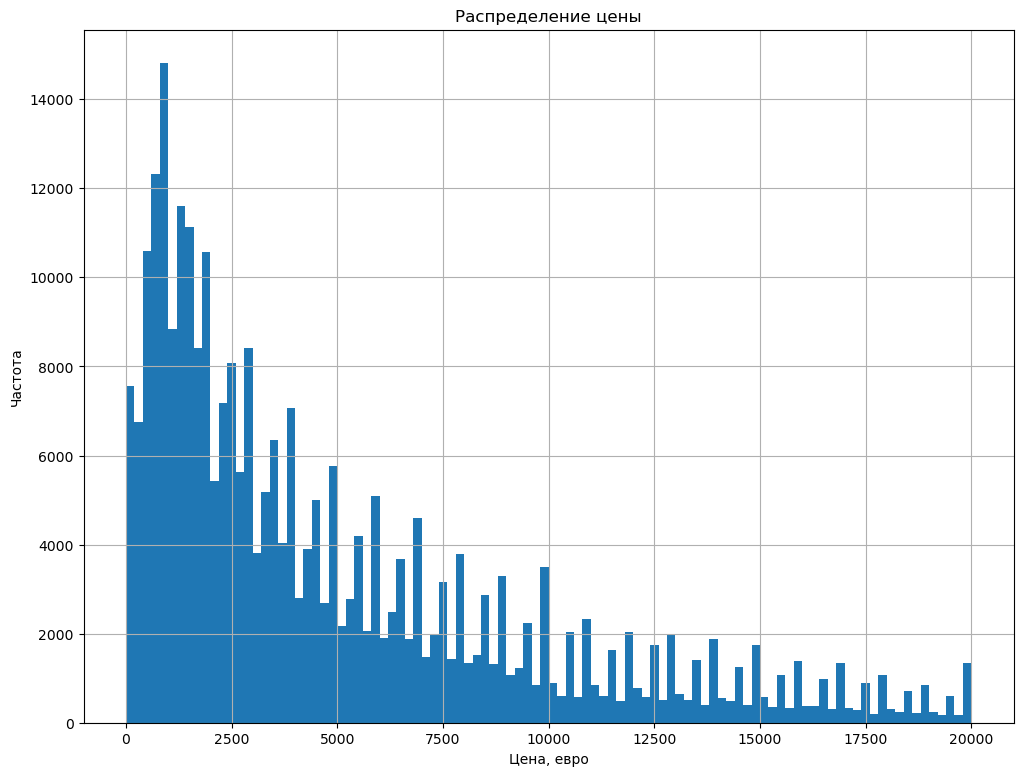

In [21]:
# визуаализируем
df['price'].hist(bins=100, figsize=(12,9))
plt.xlabel('Цена, евро')
plt.ylabel('Частота')
plt.title('Распределение цены');

Действительно, данные некорректны - большое количество автомобилей имеют нулевую и околонулевую стоимость, а некотрые стоят десятки тысяч евро. Очевидно, что некоторые данные были либо некорректно заполнены, либо произошли сбои при выгрузке базы. Попробуем ограничить выборку слева стоимостбю в 500 евро, справа же ограничим стоимостью в 14 000 евро. Оценим потерю данных, при таком способе выборки.

In [22]:
# проведем удаление аномалий и проверим
df = df.query('500 < price < 14000')
df['price'].value_counts().sort_index()

price
501        2
510       11
514        1
515        1
517        1
        ... 
13989      3
13990    261
13995     13
13998     12
13999    336
Name: count, Length: 2779, dtype: int64

#### Обработка пропусков в столбце 'repaired'

Первичный осмотр показал, что имеются пропуски. Чтобы не терять данные введем новую категорию 'unknown'.

In [23]:
# заменим пропуски новой категорией 'unknown' и проверим
df['repaired'] = df['repaired'].fillna('unknown')
print(df['repaired'].unique())
df['repaired'].isna().sum()

['unknown' 'no' 'yes']


0

In [24]:
df['gearbox'] = df['gearbox'].fillna('other')
print(df['gearbox'].unique())
df['gearbox'].isna().sum()

['auto' 'manual' 'other']


0

#### Обработка пропусков в столбце 'fuel_type'

Первичный осмотр показал, что имеются пропуски и неявные дубликаты. Сначала заменим значение gasoline на petrol, так как это разные названия бензина (в США и в Европе). Затем заполним пропущенные значения значением other.

In [25]:
# предварительная информация по значениям столбца
df['fuel_type'].value_counts()

fuel_type
petrol      156073
gasoline     74939
lpg           4235
cng            462
hybrid         150
other           65
electric        53
Name: count, dtype: int64

In [26]:
# заменяем 'gasoline' на 'petrol' и проверяем
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
df['fuel_type'].value_counts()

fuel_type
petrol      231012
lpg           4235
cng            462
hybrid         150
other           65
electric        53
Name: count, dtype: int64

In [27]:
# заменяем пропуски на 'other' и проверяем
df['fuel_type'] = df['fuel_type'].fillna('other')
print(df['fuel_type'].value_counts())
df['fuel_type'].isna().sum()

fuel_type
petrol      231012
other        10799
lpg           4235
cng            462
hybrid         150
electric        53
Name: count, dtype: int64


0

#### Обработка  столбца 'model'

Заменим неявные дубликаты rangerover на range_rover

In [28]:
df[df['model'] == 'rangerover']

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
27949,1050,small,1998,manual,103,rangerover,150000,petrol,rover,unknown
279463,3300,NaN,2017,manual,135,rangerover,150000,petrol,rover,no


In [29]:
df['model'] = df['model'].replace('rangerover', 'range_rover')

Заменим пропущенные значения на 'other'

In [30]:
# предварительная информация по значениям столбца
df['model'].value_counts()

model
golf                  20504
other                 16719
3er                   14725
polo                   8622
corsa                  7948
                      ...  
samara                    2
range_rover_evoque        2
serie_3                   2
amarok                    2
q3                        1
Name: count, Length: 247, dtype: int64

In [31]:
# заменяем пропуски на 'other' и проверяем
df['model'] = df['model'].fillna('other')
print(df['model'].value_counts())
df['model'].isna().sum()

model
other                 24457
golf                  20504
3er                   14725
polo                   8622
corsa                  7948
                      ...  
samara                    2
range_rover_evoque        2
serie_3                   2
amarok                    2
q3                        1
Name: count, Length: 247, dtype: int64


0

#### Обработка пропусков в столбце 'vehicle_type'

Проведем замену пропусков по следующей логике: для каждой модели автомобиля найдем наиболее часто встречающийся тип кузова, заменим пропуски на найденное значение. согласно конкретной модели автомобиля.

In [32]:
# предварительная информация по значениям столбца
print(df['vehicle_type'].value_counts())
df['vehicle_type'].isna().sum()

vehicle_type
sedan          70207
small          57273
wagon          49706
bus            23128
convertible    15306
coupe          10970
suv             7993
other           1853
Name: count, dtype: int64


10275

In [33]:
# функция нахождения наиболее часто встречающегося типа кузова для конкретной модели автомобиля
def mode_vehicle_type(model,df):
    res = df.query('model == @model and vehicle_type != "NaN"')['vehicle_type'].value_counts().index[0]
    return res

In [34]:
# произведем замену пропусков самой популярной конфигурацие кузова для каждой модели и проверим
for model in list(df['model'].unique()):
    df.loc[df['model'] == model, 'vehicle_type'] = df['vehicle_type'].fillna(mode_vehicle_type(model,df))
print(df['vehicle_type'].value_counts())
df['vehicle_type'].isna().sum()

vehicle_type
sedan          75703
small          59620
wagon          50697
bus            24262
convertible    15374
coupe          11079
suv             8121
other           1855
Name: count, dtype: int64


0

**Проверим весь датафрейм на пропуски**

In [35]:
# проверка
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Таким образом в результате предобработки данных была проведена следующая работа:

- названия столбцов приведины к "змеиному стилю";
- удалены явные дубликаты;
- удалены незначимые для машинного обучения столбцы:'number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled';
- выбросы в столбце 'registration_year' были удалены, рассматриевамый период регистрации автомобилей с 1960 по март 2016 года;
- обработаны аномальные значения в столбце 'power': данные по автомобилям с мощностью более 1000 л.с. и менее 10 л.с. были удалены, 
- выбросы в столбце 'price' были удалены, рассматриевамый рассматриваемый диапазон цен от 500 до 14000 евро;
- пропуски в столбце 'repaired' заменены новой категорией 'unknown';
- в столбце 'fuel_type' значения  gasoline были перезаписаны как petrol, пропуски заменены на'other';
- в столбце 'model' проработы неявные дубликаты, пропуски заменены на'other';
- в столбце 'vehicle_type' пропуски были заменены на самый популярный тип кузова для конкретной модели автомобиля;

## Обучение моделей

Целевой признак у нас количественный, непрерывный. Тогда для обучения будем использовать модели регресии: LinearRegression, DecisionTreeRegressor и LGBMRegressor. В качестве метрики будем использовать RMSE.

### Подготовка выборок

#### Деление на тренировочную и тестовую выборки

In [36]:
# создадим копию датафрейма
data = df.copy()
data.reset_index(drop= True , inplace= True)

In [37]:
# отделим признаки от целевого признака
target = data['price']
features = data.drop('price', axis=1)

# разделим выборки на тренировочные и тестовые в соотношении 75/25
features_train, features_test, target_train, target_test\
= train_test_split(features, target, test_size=0.25, random_state=12345) 

print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(185033, 9) (61678, 9)
(185033,) (61678,)


#### Подготовка данных для LinearRegression

In [38]:
# определим списки столбцов по типам
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'model', 'brand'] # категориальные столбцы 
num_columns = ['registration_year', 'power', 'kilometer'] # числовые столбцы 


In [39]:
# скопируем признаки для OHE кодирования
features_train_ohe = features_train.copy() 
features_test_ohe = features_test.copy()

In [40]:
# проведем OHE кодирование категориальных признаков на трейне
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_columns])
features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[cat_columns])
features_train_ohe = features_train_ohe.drop(cat_columns, axis=1)

# проведем OHE кодирование категориальных признаков на тесте
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe[cat_columns])
features_test_ohe = features_test_ohe.drop(cat_columns, axis=1)

In [41]:
# масштабируем числовые признаки на трейне
scaler = StandardScaler()
scaler.fit(features_train_ohe[num_columns])
features_train_ohe[num_columns] = scaler.transform(features_train_ohe[num_columns])

# масщтабируем числовые признаки на тесте
features_test_ohe[num_columns] = scaler.transform(features_test_ohe[num_columns])

In [42]:
# сравним размерности полученных выборок
print(features_train_ohe.shape, features_test_ohe.shape)

(185033, 304) (61678, 304)


#### Подготовка данных для DecisionTreeRegressor

In [43]:
# скопируем признаки для ORD кодирования
features_train_ord = features_train.copy() 
features_test_ord = features_test.copy()

In [44]:
# проведем ORD кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)

In [45]:
# проведем кодирование ORD на трейне
cat_features_ord = features_train_ord[cat_columns]
cat_features_ord = pd.DataFrame(encoder.fit_transform(cat_features_ord),
                                columns=cat_features_ord.columns, 
                                index=cat_features_ord.index)
for column in cat_columns:
    features_train_ord[column] = cat_features_ord[column]

# проведем кодирование ORD на тесте
cat_features_ord = features_test_ord[cat_columns]
cat_features_ord = pd.DataFrame(encoder.transform(cat_features_ord),
                                columns=cat_features_ord.columns, 
                                index=cat_features_ord.index)
for column in cat_columns:
    features_test_ord[column] = cat_features_ord[column]

In [46]:
# масштабируем числовые признаки на трейне
scaler = StandardScaler()
scaler.fit(features_train_ord[num_columns])
features_train_ord[num_columns] = scaler.transform(features_train_ord[num_columns])

# масщтабируем числовые признаки на тесте
features_test_ord[num_columns] = scaler.transform(features_test_ord[num_columns])

In [47]:
features_test_ord.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
106062,7.0,0.490547,1.0,-0.637167,141.0,-0.140180,5.0,6.0,0.0
154879,0.0,-0.121726,1.0,0.111754,246.0,-1.430034,5.0,24.0,2.0
73707,5.0,0.388502,1.0,-0.873669,83.0,-0.140180,5.0,24.0,0.0
201284,7.0,-0.223771,0.0,1.668721,95.0,0.576405,5.0,20.0,0.0
143631,4.0,0.592593,1.0,0.466506,6.0,0.576405,5.0,2.0,0.0


In [48]:
# сравним размерности полученных выборок
print(features_train_ord.shape, features_test_ord.shape)

(185033, 9) (61678, 9)


В ходе подготовки данных для обучения моделей были проделаны следующие работы:
- признаки отделены от целевого признака, проведено разделение выборок на тренировочную и тестовую в соттношении 75/25;
- проведено ОНЕ кодирование для линейных моделей;
- проведено ОRD кодирование для нелинейных моделей;
- проведено масштабирование числовых признаков.

### Обучение моделей

#### Модель LinearRegression

In [49]:
# пустой словар для кросс-валидации
param_lr = {}
# инициализируем модель и подбор параметров
model_lr = LinearRegression()
tuning_model_lr=GridSearchCV(estimator=model_lr,
                          param_grid=param_lr,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=-1)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_lr.fit(features_train_ohe, target_train)
rmse_lr = tuning_model_lr.best_score_*-1
print(rmse_lr)

2546.0138386614003


Лучшее значение метрики RMSE на кросс-валидации: 2546.013838661401

#### Модель DecisionTreeRegressor

In [50]:
# зададим список варьируемых параметров
param_dt= { 
            "splitter":("best", "random"), 
            "max_depth":(list(range(1, 20, 2))), 
            "min_samples_split":[2, 3, 4], 
            "min_samples_leaf":list(range(1, 20, 2)), 
           }
    

# инициализируем модель и подбор параметров
model_dt = DecisionTreeRegressor(random_state=12345)
tuning_model_dt=GridSearchCV(estimator=model_dt,
                          param_grid=param_dt,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=-1)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_dt.fit(features_train_ord, target_train)
best_model_dt = tuning_model_dt.best_params_
display(best_model_dt)
rmse_dt = tuning_model_dt.best_score_*-1
print(rmse_dt)

{'max_depth': 19,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'splitter': 'best'}

1482.413255366253


Лучшее значение метрики RMSE: 1482.413255366253  
Параметры для лучшей модели: {'max_depth': 19, 'min_samples_leaf': 9, 'min_samples_split': 2, 'splitter': 'best'}

#### Модель LGBMRegressor

In [51]:
# так как в данной модели кодировка происходит по иному принципу, то нам понадобится датафрейм, полученный после предобработки
df_gb = df.copy()

In [52]:
# захделяем признаки и целевой признак
target_gb = df_gb['price']
features_gb = df_gb.drop('price', axis=1)

In [54]:
# переведем категориальные признаки в тип category, который требуется для LightGBM
for c in features_gb.columns:
    col_type = features_gb[c].dtype
    if col_type == 'object':
        features_gb[c] = features_gb[c].astype('category')

#разделим выборки на обучающую и тестовую
features_train_gb, features_test_gb, target_train_gb, target_test_gb\
= train_test_split(features_gb, target_gb, test_size=0.25, random_state=12345) 

# проверим размер выборок
print(features_train_gb.shape)
print(features_test_gb.shape)

(185033, 9)
(61678, 9)


In [55]:
# зададим список варьируемых параметров
param_grid = {'n_estimators': [100, 500, 1000], 'num_leaves': [n for n in range(20, 300, 50)]}

In [56]:
# инициализируем модель и подбор параметров
model = lgb.LGBMRegressor(random_state=12345, verbose=-1)

tuning_model_gb=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=-1)

# приступим к обучению с определением лучших параметров и RSME
tuning_model_gb.fit(features_train_gb, target_train_gb)
best_model_gb = tuning_model_gb.best_params_
display(tuning_model_gb.best_params_)
rsme_gb = tuning_model_gb.best_score_*-1
print(rsme_gb)

{'n_estimators': 500, 'num_leaves': 170}

1286.624461444039


In [57]:
best_model_gb = tuning_model_gb.best_params_
display(tuning_model_gb.best_params_)
rsme_gb = tuning_model_gb.best_score_*-1
print(rsme_gb)

{'n_estimators': 500, 'num_leaves': 170}

1286.624461444039


Лучшее значение метрики RMSE: 1286.624461444039
Параметры для лучшей модели: {'n_estimators': 500, 'num_leaves': 170}

По результату обучения моделей можно сказать следующее:
- обучены 3 модели: LinearRegression, DecisionTreeRegressor и LGBMRegressor;
- для каждой модели проведен подбор наилучших параметров с помощью оценщика;
- на тренировочных данных лучшее значение RMSE = 1286.624461444039 достигнуто для модели LGBMRegressor;

## Анализ моделей

Проведем обучение моделей на лучших параметрах.

### Модель LinearRegression

In [58]:
# найдем время обучения модели линейной регрессии
start = time()

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train)

end = time()

model_time_fit_lr = (end-start)/60 
model_time_fit_lr

0.06594296296437581

In [59]:
# найдем время предсказания на  трейне
start = time()

target_predict_lr = model_lr.predict(features_train_ohe)

end = time()

model_time_pred_lr = (end-start)/60 
model_time_pred_lr

0.0036502718925476075

### Модель DecisionTreeRegressor

In [60]:
# найдем время обучения модели решающего дерева
start = time()

model_dt = DecisionTreeRegressor(random_state=12345, **best_model_dt)
model_dt.fit(features_train_ord, target_train)

end = time()

model_time_fit_dt = (end-start)/60
model_time_fit_dt

0.007569603125254313

In [61]:
# найдем время предсказания на трейне
start = time()
target_predict = model_dt.predict(features_train_ord)

end = time()

model_time_pred_dt = (end-start)/60
model_time_pred_dt

0.0007863998413085938

### Модель LGBMRegressor

In [62]:
# найдем время обучения градиентного бустинга
start = time()

model_gb = lgb.LGBMRegressor(random_state=12345, **best_model_gb)
model_gb.fit(features_train_gb, target_train_gb)

end = time()

model_time_fit_gb = (end-start)/60
model_time_fit_gb

0.06692416270573934

In [63]:
# найдем время предсказания на трейне
start = time()

target_predict_gb = model_gb.predict(features_train_gb)

end = time()

model_time_pred_gb = (end-start)/60
model_time_pred_gb

0.037005690733591716

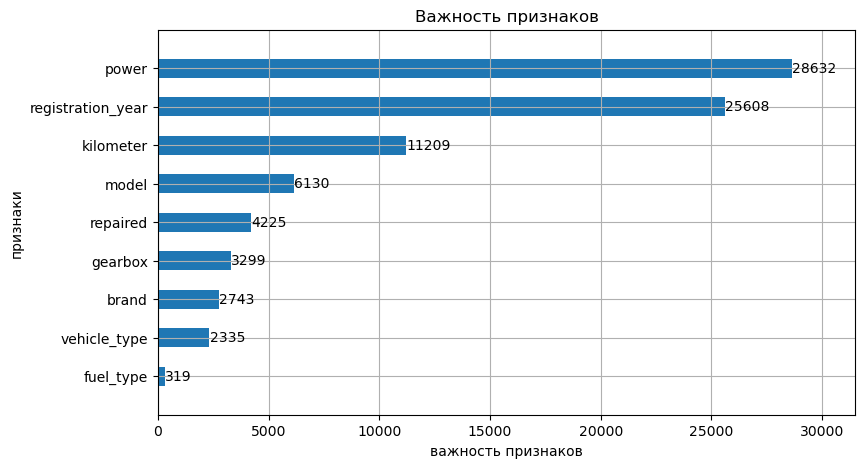

In [64]:
# посмотрим на то, какие признаки влияют больше всего
lgb.plot_importance(model_gb, height=.5, xlabel ='важность признаков', ylabel ='признаки', title='Важность признаков',\
                    figsize=(9,5));

В большей степени на цену автомобиля влияют мощность и возраст автомобиля.

### Сводные данные по моделям

In [65]:
# сформируем сводную таблицу с результатми
result = pd.DataFrame(
    [
        [rmse_lr, rmse_dt, rsme_gb],
        [model_time_fit_lr, model_time_fit_dt, model_time_fit_gb],
        [model_time_pred_lr, model_time_pred_dt, model_time_pred_gb],
        [model_time_fit_lr + model_time_pred_lr, model_time_fit_dt + model_time_pred_dt, model_time_fit_gb + model_time_pred_gb]
    ],
    index=['Результаты RMSE', 'Время обучения модели, мин', 'Время предсказания, мин', 'Суммарное время модели, мин'], 
    columns=['LinearRegression', 'DecisionTreeRegressor', 'LGBMRegressor']
)
result

,LinearRegression,DecisionTreeRegressor,LGBMRegressor
Результаты RMSE,2546.013839,1482.413255,1286.624461
"Время обучения модели, мин",0.065943,0.007570,0.066924
"Время предсказания, мин",0.003650,0.000786,0.037006
"Суммарное время модели, мин",0.069593,0.008356,0.103930


Таким образом, все модели были обучены на своих лучших параметрах на трейне, получены предсказания на трейне, замерены время обучения и предсказания, вычислена метрика качества RMSE на кросс-валидации.
Из таблицы видно, что наибольшей точностью обладает модель LGBMRegressor, но она же и самая медленная и в обучении, и в предсказании. Модель DecisionTreeRegressor так же обладает достаточно высокой точностью (немногим меньшей чем предыдущая модель), при этом быстрота вычислений на несколько порядков выше. Модель LinearRegression обладает наименьшей точностью, при среднем быстродействии. Поэтому, исходя из требований заказчика, оптимальной по показателю точность/время является DecisionTreeRegressor.

#### Тестирование выбранной модели

In [66]:
# проверим лучшую модель на тестовой выборке
target_predict = model_dt.predict(features_test_ord)

# определим метрику качества 
final_RMSE = mean_squared_error(target_test, target_predict) ** 0.5
final_RMSE

1454.33073911314

На тестовой выборке метрика качества RMSE 1454.33073911314. 

#### Проверка адекватности модели

In [67]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train_ord, target_train)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test_ord)
rmse = mean_squared_error(target_test,dummy_regr_predict)**0.5
print('Среднеквадратическая ошибка для модели Дамми составляет:', rmse)

Среднеквадратическая ошибка для модели Дамми составляет: 3449.5508067104433


Модель адекватна.

## Итоговый вывод.

**По результатам проделанной работы можно сказать следующее:**

-------------------------------------------------------------------------------------------------------------------------------
Загрузив и проведя первичный осмотр данных можно сделать следующие выводы:
  - данные загрузились корректно;
  - датафрейм содержит 354369 строк и 16 столбцов;
  - названия столбцов представлены в "верблюжьем" стиле, необходимо будет перевести в "змеиный";
  - в данных есть явные дубликаты, необходимо будет их удалить;
  - в данных незначимые для машинного обучения столбцы, а именно: DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode, LastSeen, необходимо будет их удалить;
  - в некоторых значимых столбцах есть пропуски данных, необходимо будет их обработать;
  - в категориальных столбцах наблюдается неявное дублирование в названии категорий: в столбце FuelType встречается разное название одного и того же вида топлива - бензина ('petrol' и 'gasoline'); в столбце Model - разное написание одной модели rangerover и range_rover. это нужно будет учесть в предобработке данных;
  - во всех значимых числовых столбцах присутствуют выбросы, необходимо будет проработать и этот момент;
  - данные в столбце с годом регистрации автомобиля RegistrationYear, имеют целочисленный тип, что не является помехой для наших целей, данные имеют неправдоподобные выбросы из далекого прошлого и далекого будующего, необходимо будет поработать с этими выбросами;
  - данные в столбце с годом регистрации автомобиля RegistrationMonth имеют нулевые значения, при этом основная нумерация от 1 до 12, необходимо будет поработать с этими аномальными значениями;
  - данные в столбце с пробегом так же имеют выбросы в направлении малых пробегов, но это может быть вполне реальной картиной, даже для старых автомобилей, так не редкость, что машина может просто простоять в гараже, поэтому этот столбнц оставим как есть.
-------------------------------------------------------------------------------------------------------------------------------

В результате предобработки данных была проведена следующая работа:

- названия столбцов приведины к "змеиному стилю";
- удалены явные дубликаты;
- удалены незначимые для машинного обучения столбцы:'number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled';
- выбросы в столбце 'registration_year' были удалены, рассматриевамый период регистрации автомобилей с 1960 по март 2016 года;
- обработаны аномальные значения в столбце 'power': данные по автомобилям с мощностью более 1000 л.с. и менее 10 л.с. были удалены, 
- выбросы в столбце 'price' были удалены, рассматриевамый рассматриваемый диапазон цен от 500 до 14000 евро;
- пропуски в столбце 'repaired' заменены новой категорией 'unknown';
- в столбце 'fuel_type' значения  gasoline были перезаписаны как petrol, пропуски заменены на'other';
- в столбце 'model' проработы неявные дубликаты, пропуски заменены на'other';
- в столбце 'vehicle_type' пропуски были заменены на самый популярный тип кузова для конкретной модели автомобиля;
-------------------------------------------------------------------------------------------------------------------------------

В ходе подготовки данных для обучения моделей были проделаны следующие работы:
- признаки отделены от целевого признака, проведено разделение выборок на тренировочную и тестовую в соттношении 75/25;
- проведено ОНЕ кодирование для линейных моделей;
- проведено ОRD кодирование для нелинейных моделей;
- проведено масштабирование числовых признаков.
-------------------------------------------------------------------------------------------------------------------------------

По результату обучения моделей можно сказать следующее:
- обучены 3 модели: LinearRegression, DecisionTreeRegressor и LGBMRegressor;
- для каждой модели проведен подбор наилучших параметров с помощью оценщика;
- на тренировочных данных лучшее значение RMSE = 1286.6244614440392 достигнуто для модели LGBMRegressor;
-------------------------------------------------------------------------------------------------------------------------------

Таким образом, все модели были обучены на своих лучших параметрах на трейне, получены предсказания на трейне, замерены время обучения и предсказания, вычислена метрика качества RMSE на кросс-валидации.


||LinearRegression|	DecisionTreeRegressor|	LGBMRegressor|
|-|----------------|-----------------------|---------------|
Результаты  RMSE|	2546.015817|	1482.411836|1286.62446|
Время обучения модели, мин|0.265134|0.007601|0.675052
Время предсказания, мин|	0.002279|	0.000663|	0.321410|
Суммарное время модели, мин|0.267413|0.008263|0.996462|




Из таблицы видно, что наибольшей точностью обладает модель LGBMRegressor, но она же и самая медленная и в обучении, и в предсказании.Модель DecisionTreeRegressor так же обладает достаточно высокой точностью (немногим меньшей чем предыдущая модель), при этом быстрота вычислений на несколько порядков выше. Модель LinearRegression обладает наименьшей точностью, при среднем быстродействии. 

Поэтому, исходя из требований заказчика, оптимальной по показателю точность/время является DecisionTreeRegressor.
Выбранная модель на тестовых данных показала метрику RMSE = 1454.33073911314.
Модель была проверена на адекватность, модель адекватна.

-------------------------------------------------------------------------------------------------------------------------------
**Таким образом заказчику можно порекомендовать  модель DecisionTreeRegressor.**